In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from itertools import product

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 30)

### Optimized Portfolio of Sector Indexes

In [19]:
# list of index tickers
symbols = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']

In [20]:
# retrieving data for each sector index
# from 2010 - 2024
# get last month (currently the last month is September) of each year
data = [
    pd.DataFrame(yf.Ticker(symbol).history(start = '2010-01-01', end = '2024-09-18', interval = '3mo'))
    .reset_index()[::-4].sort_values(by = 'Date')
    for symbol in symbols
]

# clean up index of each df - problem is that a couple sector indexes (XLC and XLRE) haven't been around since 2010 like all the other indexes so their
# data doesn't have that index, and then there's a whole mismatching thing and whatnot - this solves that
cleaned_data = [
   df.set_index(np.arange(15 - df.shape[0], 15, 1)) for df in data 
]

In [21]:
# year-to-year return series for each sector index
returns = [
    df['Close'].pct_change()
    for df in cleaned_data
]

# make return series into a dataframe to be able to run .corr() in a later step
df_returns = pd.DataFrame(returns).loc[:, np.arange(0, 15, 1)].assign(symbol = symbols).set_index('symbol').T

In [22]:
# calculate expected/mean returns
means = [
    return_.mean() # get mean return
    for return_ in returns
]

# calculate standard deviations of returns
stds = [
    return_.std() # get std dev of returns
    for return_ in returns
]

In [23]:
# make a dataframe for the important data (expected returns, standard deviations, correlations, covariances)
df = pd.DataFrame()

df['symbol'] = symbols
df['exp_return'] = means
df['std_dev'] = stds

# set index to ticker symbol
df = df.set_index('symbol')

In [24]:
# calculate correlation between each sector indexes' returns
df_corr = df_returns.corr()
# rename columns to include '_corr'
df_corr = df_corr.rename(columns = {col: col + '_corr' for col in df_corr.columns})

df = pd.concat([df, df_corr], axis = 1)

In [25]:
# each possible 2-unit combination of ticker symbols (self-pairing included) - these combinations will be used to calculate covariances based on
# standard deviations and correlations
combs = [i for i in product(symbols, repeat = 2)]

# create covariances dataframe to concatenate to main df
df_covariances = pd.DataFrame()
for symbol in symbols:
    covariances = []
    for comb in combs:
        if comb[0] == symbol:
            std1 = df.loc[comb[0]]['std_dev']
            std2 = df.loc[comb[1]]['std_dev']
            corr = df.loc[comb[0], comb[1] + '_corr']
            cov = std1 * std2 * corr
            covariances.append(cov)
    df_covariances[symbol] = covariances

# rename columns to include '_cov'
df_covariances = df_covariances.T.rename(columns = {i: symbol + '_cov' for i, symbol in zip(np.arange(0, 11, 1), symbols)})

# concat covariances to main df - this completes the main df
df = pd.concat([df, df_covariances], axis = 1)

In [26]:
df

,exp_return,std_dev,XLC_corr,XLY_corr,XLP_corr,XLE_corr,XLF_corr,XLV_corr,XLI_corr,XLB_corr,XLRE_corr,XLK_corr,XLU_corr,XLC_cov,XLY_cov,XLP_cov,XLE_cov,XLF_cov,XLV_cov,XLI_cov,XLB_cov,XLRE_cov,XLK_cov,XLU_cov
XLC,0.153937,0.239113,1.000000,0.867303,0.526211,-0.338174,0.407727,0.538545,0.708741,0.793462,0.439627,0.907765,0.028080,0.057175,0.029612,0.009719,-0.025698,0.022369,0.014504,0.025982,0.028249,0.020293,0.039363,0.000798
XLY,0.156998,0.142790,0.867303,1.000000,0.396424,-0.046211,0.570196,0.794287,0.676837,0.564574,0.402377,0.656923,-0.075665,0.029612,0.020389,0.004372,-0.002097,0.018680,0.012775,0.014817,0.012003,0.011091,0.017011,-0.001284
XLP,0.113593,0.077244,0.526211,0.396424,1.000000,-0.060729,0.448781,0.465496,0.517000,0.525792,0.859273,0.292627,0.710965,0.009719,0.004372,0.005967,-0.001491,0.007954,0.004050,0.006123,0.006047,0.012813,0.004099,0.006528
XLE,0.111662,0.317799,-0.338174,-0.046211,-0.060729,1.000000,0.468635,0.155614,0.363630,0.344219,0.124692,-0.081035,-0.041520,-0.025698,-0.002097,-0.001491,0.100996,0.034171,0.005570,0.017717,0.016288,0.007650,-0.004670,-0.001568
XLF,0.143569,0.229437,0.407727,0.570196,0.448781,0.468635,1.000000,0.655294,0.881981,0.766369,0.735041,0.423145,0.345337,0.022369,0.018680,0.007954,0.034171,0.052641,0.016935,0.031025,0.026181,0.032556,0.017606,0.009418
XLV,0.147989,0.112635,0.538545,0.794287,0.465496,0.155614,0.655294,1.000000,0.733777,0.720975,0.364718,0.587533,0.055760,0.014504,0.012775,0.004050,0.005570,0.016935,0.012687,0.012671,0.012091,0.007930,0.012001,0.000747
XLI,0.139916,0.153314,0.708741,0.676837,0.517000,0.363630,0.881981,0.733777,1.000000,0.895329,0.620080,0.612438,0.237312,0.025982,0.014817,0.006123,0.017717,0.031025,0.012671,0.023505,0.020438,0.018352,0.017028,0.004325
XLB,0.111861,0.148895,0.793462,0.564574,0.525792,0.344219,0.766369,0.720975,0.895329,1.000000,0.555556,0.725971,0.201325,0.028249,0.012003,0.006047,0.016288,0.026181,0.012091,0.020438,0.022170,0.015969,0.019603,0.003563
XLRE,0.091537,0.193044,0.439627,0.402377,0.859273,0.124692,0.735041,0.364718,0.620080,0.555556,1.000000,0.248345,0.784660,0.020293,0.011091,0.012813,0.007650,0.032556,0.007930,0.018352,0.015969,0.037266,0.008694,0.018006
XLK,0.205261,0.181347,0.907765,0.656923,0.292627,-0.081035,0.423145,0.587533,0.612438,0.725971,0.248345,1.000000,-0.075547,0.039363,0.017011,0.004099,-0.004670,0.017606,0.012001,0.017028,0.019603,0.008694,0.032887,-0.001629


In [58]:
# 1000 samples of dirichlet distributions of weights
samples = np.random.dirichlet(np.ones(11), 100000)

In [59]:
# looping through each dirichlet distribution
port_exp_returns = []
port_variances = []
port_std_devs = []
for weights in samples:
    port_exp_return = np.dot( weights.T, df['exp_return'] )
    port_variance = np.dot( weights.T, np.dot( df.loc[:, [symbol + '_cov' for symbol in symbols]], weights ) )
    port_std_dev = np.sqrt(port_variance)

    port_exp_returns.append(port_exp_return)
    port_variances.append(port_variance)
    port_std_devs.append(port_std_dev)

In [60]:
# create output dataframe and fill with output data
df_output = pd.DataFrame()
df_output['port_exp_return'] = port_exp_returns
df_output['port_variance'] = port_variances
df_output['port_std_dev'] = port_std_devs

In [61]:
# calculate 'rr_ratio' column as 'variance' / 'return' - risk-to-return ratio - we want to find the min value and its index and use that disribution of
# weights
df_output['rr_ratio'] = df_output['port_variance'] / df_output['port_exp_return']

In [62]:
df_output

,port_exp_return,port_variance,port_std_dev,rr_ratio
0,0.153723,0.017585,0.132609,0.114395
1,0.134252,0.010149,0.100743,0.075598
2,0.128007,0.014760,0.121489,0.115302
3,0.135967,0.015367,0.123962,0.113018
4,0.124910,0.014251,0.119379,0.114093
...,...,...,...,...
99995,0.122748,0.018389,0.135607,0.149814
99996,0.133599,0.014887,0.122011,0.111428
99997,0.139287,0.018776,0.137025,0.134799
99998,0.138214,0.010197,0.100980,0.073776


In [63]:
# find optimal portfolio allocation
optimal_rr_ratio = df_output['rr_ratio'].min()
optimal_index = df_output.loc[df_output['rr_ratio'] == optimal_rr_ratio].index
optimal_exp_return = df_output.loc[optimal_index, 'port_exp_return'].values[0]
optimal_variance = df_output.loc[optimal_index, 'port_variance'].values[0]
optimal_weights = samples[optimal_index]

In [64]:
# add 'optimal_weights' column on to main df
df['optimal_weights'] = optimal_weights[0]

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.0598
Variance: 0.0084
Expected Return: 0.1396
__________________________________________________


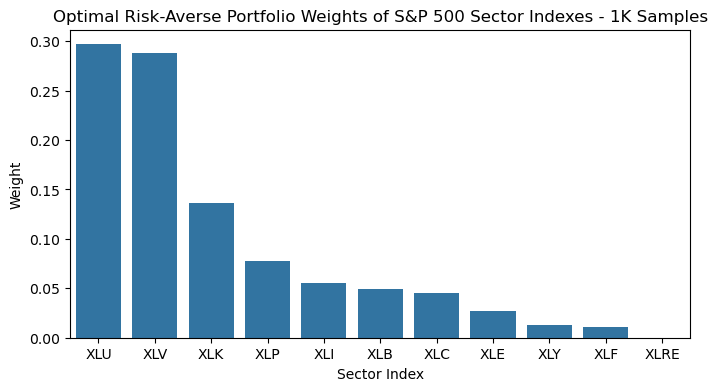

In [49]:
# visualize the final weights for 1000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Variance:', round(optimal_variance, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 1K Samples')
plt.show()

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.055
Variance: 0.007
Expected Return: 0.1274
__________________________________________________


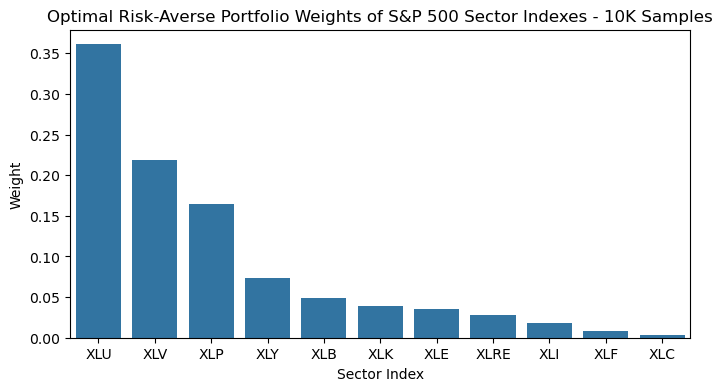

In [57]:
# visualize the final weights for 10,000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Variance:', round(optimal_variance, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 10K Samples')
plt.show()

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.0473
Variance: 0.0062
Expected Return: 0.1302
__________________________________________________


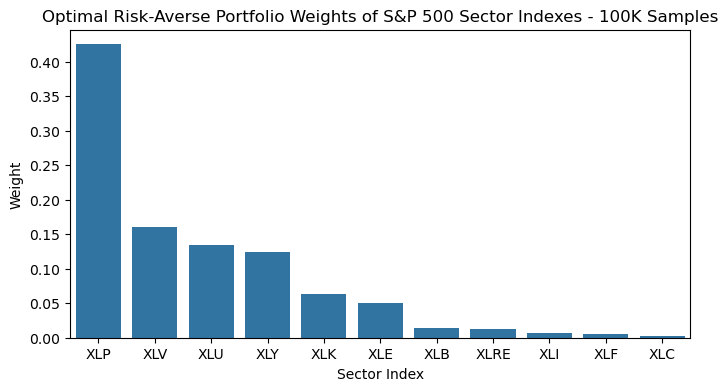

In [65]:
# visualize the final weights for 100,000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Variance:', round(optimal_variance, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 100K Samples')
plt.show()

In [69]:
df['optimal_weights'].sort_values(ascending = False).reset_index()

,index,optimal_weights
0,XLP,0.424869
1,XLV,0.160414
2,XLU,0.134625
3,XLY,0.124478
4,XLK,0.063936
5,XLE,0.050986
6,XLB,0.013817
7,XLRE,0.011988
8,XLI,0.006998
9,XLF,0.005051
